## Morphological Ops

* https://paper.dropbox.com/doc/Morphological-Operations-yK9I3QIjNkhrZRsIoJn3X

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

## Data

In [7]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIG_SIZE = (5,8)

## Helpers

In [8]:
def plot_img(arr, fs=FIG_SIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(img_fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1], color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

## Thresholding

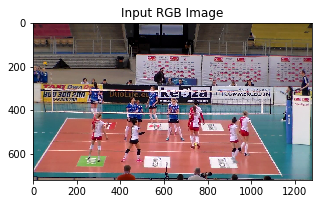

In [9]:
# Input Image
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
plot_img(img, title="Input RGB Image")

BGR: [ 93 104 199]
RGB: [199 104  93]
HSV: [  3 136 199]
Min [ 139.   44.   33.]
Max [ 255.  164.  153.]


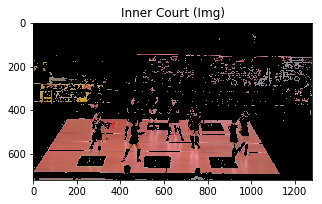

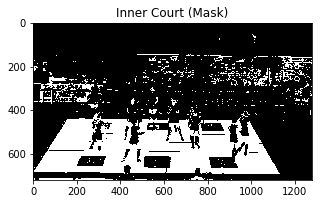

In [10]:
# Highlight inner court
color = get_color_of_pixel(img_fpath, 700, 650, 'RGB')
inner_mask, inner_result = threshold_color(img, color, 60)
plot_img(inner_result, title="Inner Court (Img)")
plot_img(inner_mask, title="Inner Court (Mask)")

BGR: [137 127  79]
RGB: [ 79 127 137]
HSV: [ 95 108 137]
Min [ 19.  67.  77.]
Max [ 139.  187.  197.]


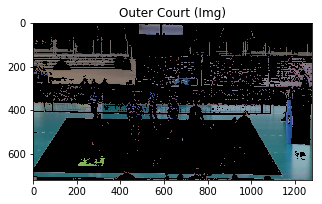

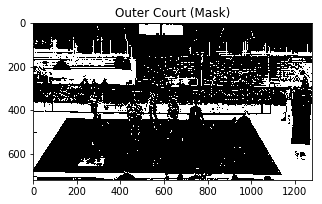

In [11]:
# Highlight Outer court
color = get_color_of_pixel(img_fpath, 1130, 460, 'RGB')
outer_mask, outer_result = threshold_color(img, color, 60)
plot_img(outer_result, title="Outer Court (Img)")
plot_img(outer_mask, title="Outer Court (Mask)")

## Erosion (Thinning)

* Erodes away boundaries of objects
* Kernel slides through and returns 1 only if all neighbors are also 1
* Thickness or size of object decreases (boundary pixels are disgarded
* Use cases
    * Removing noise around edges
    * Detaching two connected objects

### Inner Court

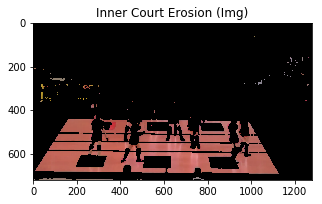

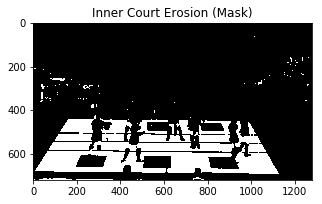

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))

# Img
inner_erode_img = cv2.erode(inner_result, kernel,iterations = 2)
plot_img(inner_erode_img, title="Inner Court Erosion (Img)")

# Mask
inner_erode_mask = cv2.erode(inner_mask, kernel,iterations = 2)
plot_img(inner_erode_mask, title="Inner Court Erosion (Mask)")

### Outer Court

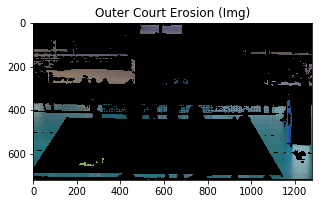

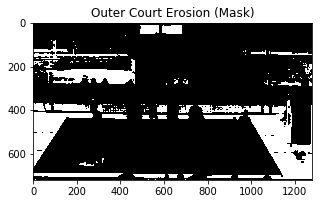

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))

# Img
outer_erode_img = cv2.erode(outer_result, kernel,iterations = 2)
plot_img(outer_erode_img, title="Outer Court Erosion (Img)")

# Mask
outer_erode_mask = cv2.erode(outer_mask, kernel,iterations = 2)
plot_img(outer_erode_mask, title="Outer Court Erosion (Mask)")

## Dilation (Thickening)

* Opposite of erosion
* Expands object around edges
* Useful for joining broken parts of an image
* Typically we erode first (to remove noise around edges), then dilate to increase size of object
* Use cases
    * Increasing side of object after erosion
    * Joining broken parts of an object
    
* Structural Elements
    * Shape of kernel
    * Emphasize / target specific objects
    * Circle, Elipse, Box (Rectange), custom
    
![Ellipse](https://study.com/cimages/multimages/16/semimajax2.jpg)

### Inner Court

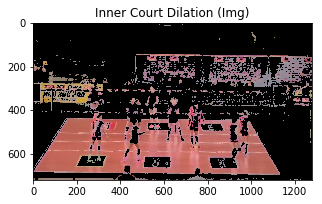

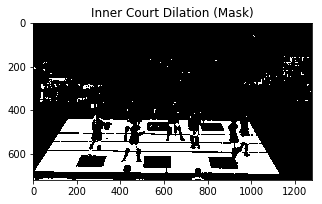

In [14]:
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))

# Img
inner_dilate_img = cv2.dilate(inner_result, kernel,iterations = 2)
plot_img(inner_dilate_img, title="Inner Court Dilation (Img)")

# Mask
inner_dilate_mask = cv2.erode(inner_mask, kernel,iterations = 2)
plot_img(inner_dilate_mask, title="Inner Court Dilation (Mask)")

### Outer Court

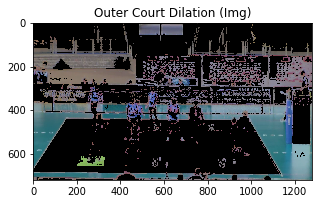

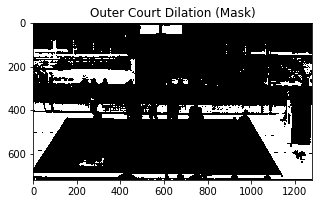

In [15]:
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))

# Img
outer_dilate_img = cv2.dilate(outer_result, kernel,iterations = 2)
plot_img(outer_dilate_img, title="Outer Court Dilation (Img)")

# Mask
outer_dilate_mask = cv2.erode(outer_mask, kernel,iterations = 2)
plot_img(outer_dilate_mask, title="Outer Court Dilation (Mask)")

## Opening (Expanding Gaps)

* Erosion --> Dilation
* Good for separating objects
* Separates nearby edges
* Maintains original size of objects

Use case
* Remove small dots / speckles around object

### Inner Court

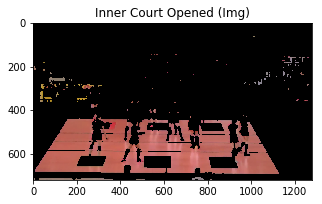

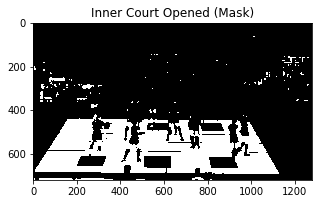

In [16]:
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))

# Image
inner_erode_img = cv2.erode(inner_result, erode_kernel, iterations = 2)
inner_opened_img = cv2.dilate(inner_erode_img, dilate_kernel, iterations = 2)
plot_img(inner_opened_img, title="Inner Court Opened (Img)")

# Mask
inner_erode_mask = cv2.erode(inner_mask, erode_kernel, iterations = 2)
inner_opened_mask = cv2.dilate(inner_erode_mask, dilate_kernel, iterations = 2)
plot_img(inner_opened_mask, title="Inner Court Opened (Mask)")

### Outer Court

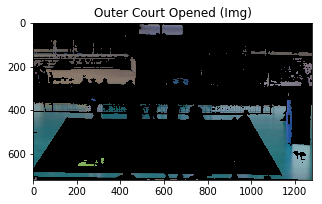

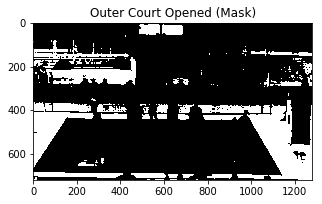

In [17]:
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))

# Image
outer_erode_img = cv2.erode(outer_result, erode_kernel, iterations = 2)
outer_opened_img = cv2.dilate(outer_erode_img, dilate_kernel, iterations = 2)
plot_img(outer_opened_img, title="Outer Court Opened (Img)")

# Mask
outer_erode_mask = cv2.erode(outer_mask, erode_kernel, iterations = 2)
outer_opened_mask = cv2.dilate(outer_erode_mask, dilate_kernel, iterations = 2)
plot_img(outer_opened_mask, title="Outer Court Opened (Mask)")

## Closing (Filling Gaps)

* Dilation --> Erosion
* Good for filling in holes
* Connects nearby edges
* Maintains original size of object

Use case
* Growing small objects / thin edges

### Inner Court

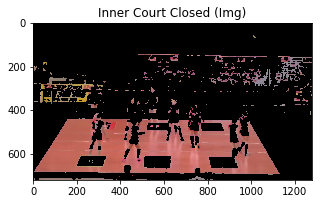

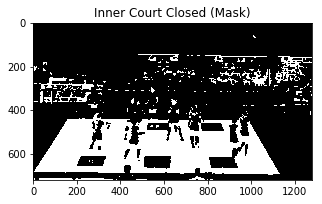

In [18]:
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))

# Image
inner_dilated_img = cv2.dilate(inner_result, dilate_kernel, iterations = 2)
inner_closed_img = cv2.erode(inner_dilated_img, erode_kernel, iterations = 2)
plot_img(inner_closed_img, title="Inner Court Closed (Img)")

# Mask
inner_dilated_mask = cv2.dilate(inner_mask, dilate_kernel, iterations = 2)
inner_closed_mask = cv2.erode(inner_dilated_mask, erode_kernel, iterations = 2)
plot_img(inner_closed_mask, title="Inner Court Closed (Mask)")

### Outer Court

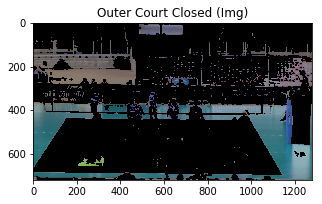

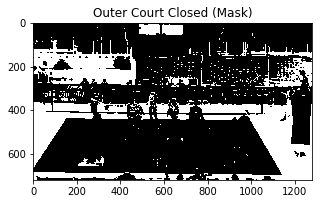

In [19]:
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))

# Image
outer_dilated_img = cv2.dilate(outer_result, dilate_kernel, iterations = 2)
outer_closed_img = cv2.erode(outer_dilated_img, erode_kernel, iterations = 2)
plot_img(outer_closed_img, title="Outer Court Closed (Img)")

# Mask
outer_dilated_mask = cv2.dilate(outer_mask, dilate_kernel, iterations = 2)
outer_closed_mask = cv2.erode(outer_dilated_mask, erode_kernel, iterations = 2)
plot_img(outer_closed_mask, title="Outer Court Closed (Mask)")

## Links

* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
* https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/